In [ ]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data


In [ ]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(221)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import math
import prediction_prep as prep

import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [ ]:
# READ IN ALL DATA
ticker = 'PLTR'
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
# fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\PLTR_2021.csv')
fin_data = pd.read_csv('stock_data/{}_2021.csv'.format(ticker))

# Call custom function to get concatenated df with all features
df = prep.get_regression_df(ticker_name = str.lower(ticker),
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)

# Set up a results dictionary object
results_dict = {}

df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,272.0,95.0,367.0,25.885552,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,19.0,12.0,31.0,38.709553,0,291.0,145.5,NaN,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,341.0,130.0,471.0,27.600843,0,360.0,180.0,25.367647,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,239.0,67.0,306.0,21.895418,0,580.0,290.0,1157.894737,197.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.316741,0,0.275160
4,2021-01-05,59.0,57.0,116.0,49.137889,0,298.0,149.0,-82.697947,124.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.516378,1,-0.660916


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int64         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     321 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: CLOSE PRICE WITH SENTIMENT

### 1-Day Shift

In [ ]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['High', '5D%Change', 'Volume', 'SD_log', '6Dir', 'SD', '7Dir', '4Dir', 'Dir', '2D%Change', '4D%Change', '2Dir', 'Low', '7D%Change', '3D%Change', '3Dir', 'Daily%Change', '6D%Change', 'Open', '5Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,2Dir(t-1),Low(t-1),7D%Change(t-1),3D%Change(t-1),3Dir(t-1),Daily%Change(t-1),6D%Change(t-1),Open(t-1),5Dir(t-1),Close(t-1)
7,25.500000,2,228.0,69.0,297.0,23.232315,277.0,138.5,776.923077,96.0,...,1.0,25.510000,11.167733,4.720001,1.0,0.964134,12.023960,26.340000,1.0,26.180000
8,24.920000,3,931.0,344.0,1275.0,26.980390,1159.0,579.5,1800.000000,413.0,...,0.0,25.129999,9.114245,1.190473,1.0,-2.597404,3.658535,25.709999,1.0,25.500000
9,25.639999,4,805.0,350.0,1155.0,30.303028,1736.0,868.0,253.070175,694.0,...,0.0,24.370001,1.300812,-3.895103,0.0,-2.274510,5.862358,25.450001,0.0,24.920000
10,26.620001,1,140.0,46.0,186.0,24.731169,376.0,188.0,-79.411765,152.0,...,1.0,25.459999,8.920979,-2.062647,0.0,2.889243,2.559998,26.260000,1.0,25.639999
11,26.340000,2,213.0,80.0,293.0,27.303745,353.0,176.5,-9.745763,126.0,...,1.0,26.000000,6.480003,4.392160,1.0,3.822159,5.634921,26.809999,1.0,26.620001


In [ ]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Low(t-1),7D%Change(t-1),3D%Change(t-1),3Dir(t-1),Daily%Change(t-1),6D%Change(t-1),Open(t-1),5Dir(t-1),Close(t-1),Prediction
225,20.590000,1,2.0,0.0,2.0,0.000000,4.0,2.0,100.0,1.0,...,20.180000,-10.178339,-8.181415,0.0,-3.549744,-9.548841,21.530001,0.0,20.650000,20.590000
226,21.110001,2,8.0,4.0,12.0,33.333056,10.0,5.0,300.0,4.0,...,20.049999,-9.811650,-4.232557,0.0,-0.290554,-12.046133,20.590000,0.0,20.590000,21.110001
227,21.030001,4,16.0,3.0,19.0,15.789391,297.0,148.5,100.0,65.0,...,20.059999,-9.824858,-1.401211,0.0,2.525500,-8.733241,20.350000,0.0,21.110001,21.030001
228,21.070000,0,41.0,13.0,54.0,24.074029,132.0,66.0,100.0,29.0,...,20.349001,-9.079112,1.840199,1.0,-0.378967,-6.491770,20.410000,0.0,21.030001,21.070000
237,18.940001,4,88.0,19.0,107.0,17.756993,88.0,44.0,100.0,19.0,...,19.040001,-6.973368,2.180850,1.0,-3.077702,-0.877193,19.950001,0.0,19.209999,18.940001


In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(132, 100)
(40, 100)


In [ ]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(125, 7, 100) (125,)
(33, 7, 100) (33,)
0.8657294924649557
0.8657294924649557


In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.2898
Epoch 1: val_loss improved from inf to 0.01587, saving model to PLTR_Close_1shift_Sentiment.h5
8/8 [==============================] - 7s 417ms/step - loss: 0.2898 - val_loss: 0.0159
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.0436
Epoch 2: val_loss improved from 0.01587 to 0.01534, saving model to PLTR_Close_1shift_Sentiment.h5
8/8 [==============================] - 2s 290ms/step - loss: 0.0436 - val_loss: 0.0153
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.0219
Epoch 3: val_loss improved from 0.01534 to 0.00551, saving model to PLTR_Close_1shift_Sentiment.h5
8/8 [==============================] - 2s 287ms/step - loss: 0.0219 - val_loss: 0.0055
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.0161
Epoch 4: val_loss did not improve from 0.00551
8/8 [==============================] - 2s 260ms/step - loss: 0.0161 - val_loss: 0.0067
Epoch 5/100
8/8 

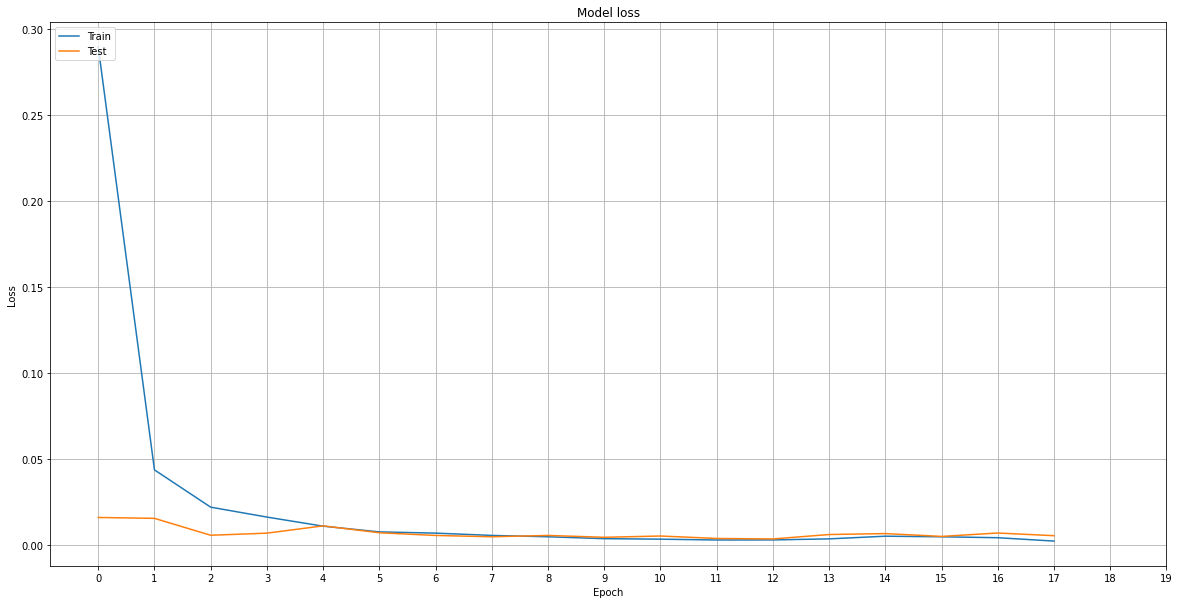

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list
results

Median Absolute Error (MAE): 1.01
Mean Absolute Percentage Error (MAPE): 4.35 %
Median Absolute Percentage Error (MDAPE): 3.46 %


,MAE,MAPE,MDAPE
0,1.014418,4.348581,3.464322


In [ ]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

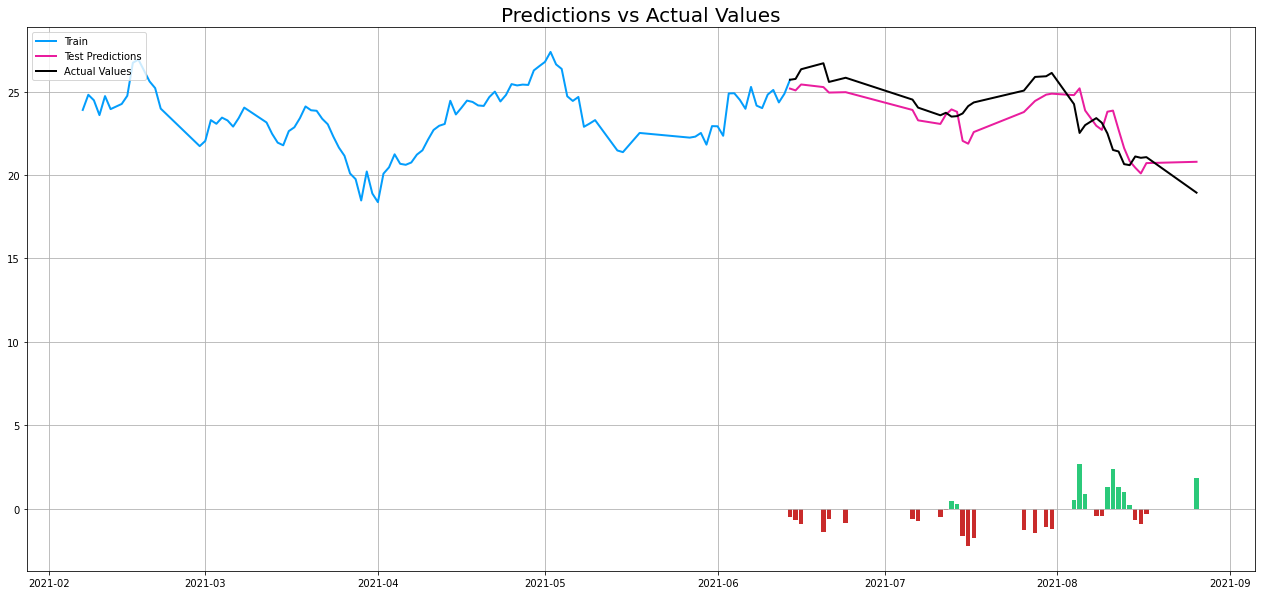

In [ ]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 4-Day Shift

In [ ]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['High', '5D%Change', 'Volume', 'SD_log', '6Dir', 'SD', '7Dir', '4Dir', 'Dir', '2D%Change', '4D%Change', '2Dir', 'Low', '7D%Change', '3D%Change', '3Dir', 'Daily%Change', '6D%Change', 'Open', '5Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,2Dir(t-4),Low(t-4),7D%Change(t-4),3D%Change(t-4),3Dir(t-4),Daily%Change(t-4),6D%Change(t-4),Open(t-4),5Dir(t-4),Close(t-4)
10,26.620001,1,2301.0,1084.0,3385.0,32.023633,3106.0,1553.0,147.153598,1434.0,...,1.0,25.510000,11.167733,4.720001,1.0,0.964134,12.023960,26.340000,1.0,26.180000
11,26.340000,2,680.0,323.0,1003.0,32.203387,2981.0,1490.5,-15.527950,1407.0,...,0.0,25.129999,9.114245,1.190473,1.0,-2.597404,3.658535,25.709999,1.0,25.500000
12,25.980000,3,236.0,106.0,342.0,30.994143,916.0,458.0,-89.743590,429.0,...,0.0,24.370001,1.300812,-3.895103,0.0,-2.274510,5.862358,25.450001,0.0,24.920000
13,32.580002,4,140.0,46.0,186.0,24.731169,376.0,188.0,-79.411765,152.0,...,1.0,25.459999,8.920979,-2.062647,0.0,2.889243,2.559998,26.260000,1.0,25.639999
14,36.230000,0,150.0,51.0,201.0,25.373122,594.0,297.0,-29.577465,214.0,...,1.0,26.000000,6.480003,4.392160,1.0,3.822159,5.634921,26.809999,1.0,26.620001


In [ ]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-4)', 'comments_positive(t-4)', 'comment_count(t-4)', 'pct_pos_comments(t-4)', 'comments_neutral_rollsum_2D(t-4)', 'comments_neutral_rollmean_2D(t-4)', 'comments_neutral_2D_pctchg(t-4)', 'comments_positive_rollsum_2D(t-4)', 'comments_positive_rollmean_2D(t-4)', 'comments_positive_2D_pctchg(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'pct_pos_comments_rollsum_2D(t-4)', 'pct_pos_comments_rollmean_2D(t-4)', 'pct_pos_comments_2D_pctchg(t-4)', 'comments_neutral_rollsum_3D(t-4)', 'comments_neutral_rollmean_3D(t-4)', 'comments_neutral_3D_pctchg(t-4)', 'comments_positive_rollsum_3D(t-4)', 'comments_positive_rollmean_3D(t-4)', 'comments_positive_3D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'pct_pos_comments_rollsum_3D(t-4)', 'pct_pos_comments_rollmean_3D(t-4)', 'pct_pos_comments_3D_pctchg(t-4)', 'comments_ne

,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,Low(t-4),7D%Change(t-4),3D%Change(t-4),3Dir(t-4),Daily%Change(t-4),6D%Change(t-4),Open(t-4),5Dir(t-4),Close(t-4),Prediction
230,19.379999,2,91.0,16.0,107.0,14.953257,91.0,45.5,468.75,16.0,...,20.059999,-9.824858,-1.401211,0.0,2.525500,-8.733241,20.35,0.0,21.110001,19.379999
231,19.690001,3,41.0,13.0,54.0,24.074029,132.0,66.0,100.00,29.0,...,20.349001,-9.079112,1.840199,1.0,-0.378967,-6.491770,20.41,0.0,21.030001,19.690001
238,18.400000,0,88.0,19.0,107.0,17.756993,88.0,44.0,100.00,19.0,...,19.070000,-7.465533,-1.168113,0.0,3.510638,-7.641199,19.26,0.0,19.459999,18.400000
239,18.639999,1,43.0,7.0,50.0,13.999972,131.0,65.5,100.00,26.0,...,19.030001,-5.932606,4.425712,1.0,1.849952,-4.019370,19.51,1.0,19.820000,18.639999
249,18.170000,2,23.0,5.0,28.0,17.857079,23.0,11.5,100.00,5.0,...,18.650000,2.608693,-0.944388,0.0,-0.105823,1.287552,18.65,1.0,18.879999,18.170000


In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(121, 100)
(37, 100)


In [ ]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(114, 7, 100) (114,)
(30, 7, 100) (30,)
0.8380998405981623
0.8380998405981623


In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.7306
Epoch 1: val_loss improved from inf to 0.03164, saving model to PLTR_Close_4shift_Sentiment.h5
8/8 [==============================] - 7s 425ms/step - loss: 0.7306 - val_loss: 0.0316
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.0470
Epoch 2: val_loss did not improve from 0.03164
8/8 [==============================] - 2s 258ms/step - loss: 0.0470 - val_loss: 0.0374
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.0319
Epoch 3: val_loss improved from 0.03164 to 0.02788, saving model to PLTR_Close_4shift_Sentiment.h5
8/8 [==============================] - 2s 286ms/step - loss: 0.0319 - val_loss: 0.0279
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.0204
Epoch 4: val_loss improved from 0.02788 to 0.01404, saving model to PLTR_Close_4shift_Sentiment.h5
8/8 [==============================] - 2s 287ms/step - loss: 0.0204 - val_loss: 0.0140
Epoch 5/100
8/8 

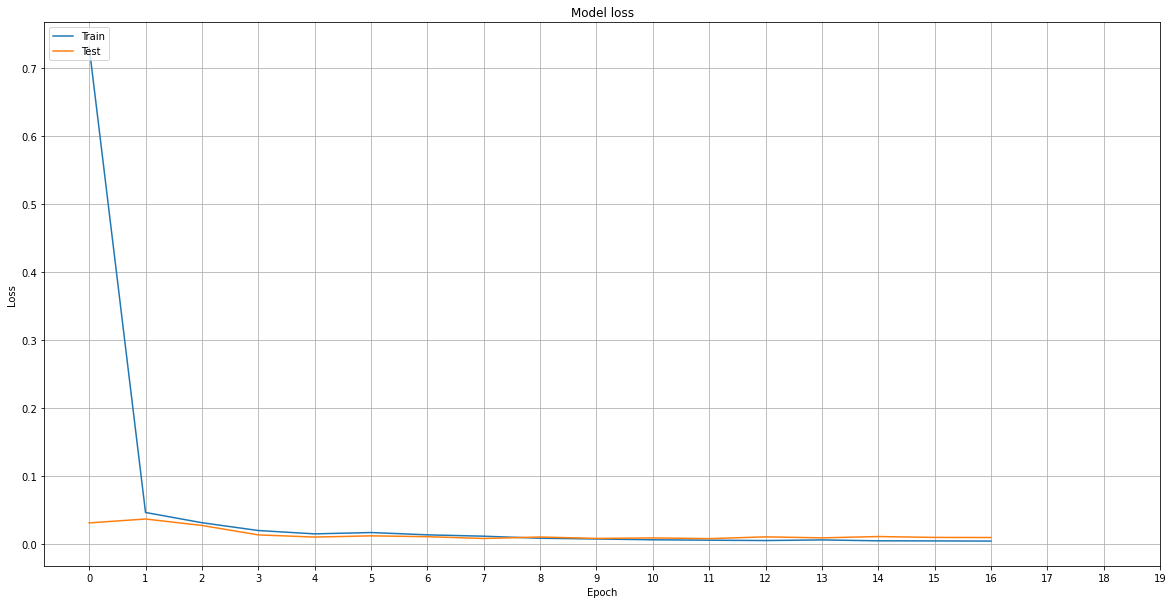

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 1.67
Mean Absolute Percentage Error (MAPE): 7.23 %
Median Absolute Percentage Error (MDAPE): 6.91 %


,MAE,MAPE,MDAPE
0,1.669695,7.230776,6.907448


In [ ]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

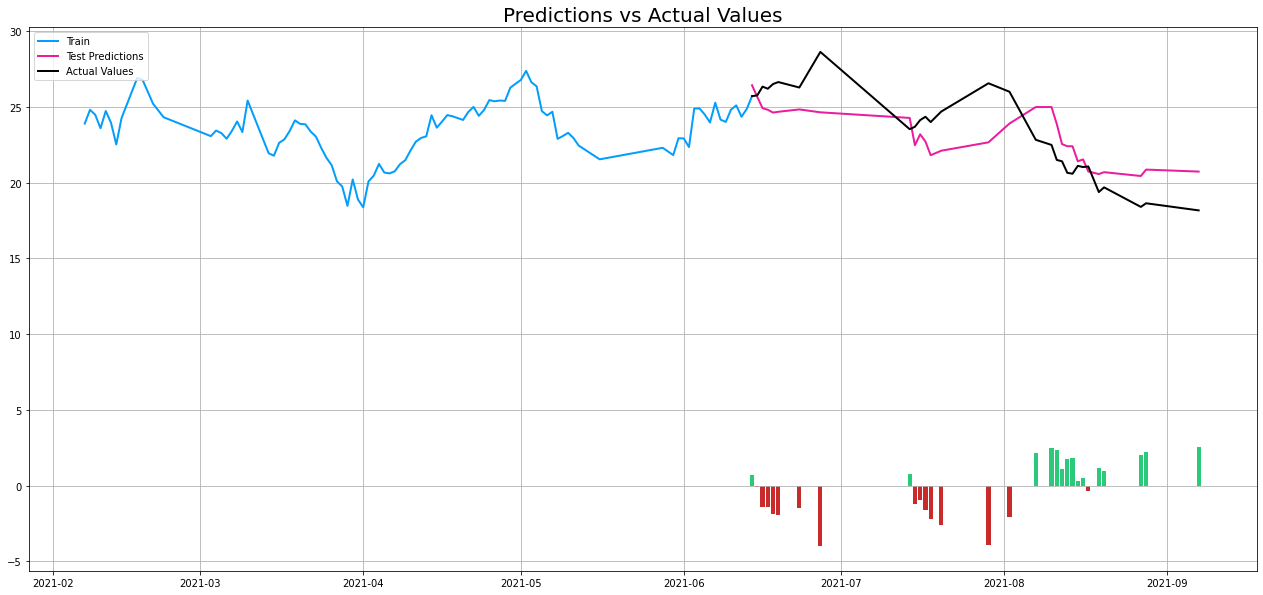

In [ ]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 7-Day Shift

In [ ]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['High', '5D%Change', 'Volume', 'SD_log', '6Dir', 'SD', '7Dir', '4Dir', 'Dir', '2D%Change', '4D%Change', '2Dir', 'Low', '7D%Change', '3D%Change', '3Dir', 'Daily%Change', '6D%Change', 'Open', '5Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,2Dir(t-7),Low(t-7),7D%Change(t-7),3D%Change(t-7),3Dir(t-7),Daily%Change(t-7),6D%Change(t-7),Open(t-7),5Dir(t-7),Close(t-7)
13,32.580002,4,2301.0,1084.0,3385.0,32.023633,3106.0,1553.0,147.153598,1434.0,...,1.0,25.510000,11.167733,4.720001,1.0,0.964134,12.023960,26.340000,1.0,26.180000
14,36.230000,0,140.0,46.0,186.0,24.731169,376.0,188.0,-79.411765,152.0,...,0.0,25.129999,9.114245,1.190473,1.0,-2.597404,3.658535,25.709999,1.0,25.500000
15,35.369999,1,213.0,80.0,293.0,27.303745,353.0,176.5,-9.745763,126.0,...,0.0,24.370001,1.300812,-3.895103,0.0,-2.274510,5.862358,25.450001,0.0,24.920000
16,39.000000,2,444.0,163.0,607.0,26.853373,657.0,328.5,217.142857,243.0,...,1.0,25.459999,8.920979,-2.062647,0.0,2.889243,2.559998,26.260000,1.0,25.639999
17,35.660000,3,150.0,51.0,201.0,25.373122,594.0,297.0,-29.577465,214.0,...,1.0,26.000000,6.480003,4.392160,1.0,3.822159,5.634921,26.809999,1.0,26.620001


In [ ]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-7)', 'comments_positive(t-7)', 'comment_count(t-7)', 'pct_pos_comments(t-7)', 'comments_neutral_rollsum_2D(t-7)', 'comments_neutral_rollmean_2D(t-7)', 'comments_neutral_2D_pctchg(t-7)', 'comments_positive_rollsum_2D(t-7)', 'comments_positive_rollmean_2D(t-7)', 'comments_positive_2D_pctchg(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'pct_pos_comments_rollsum_2D(t-7)', 'pct_pos_comments_rollmean_2D(t-7)', 'pct_pos_comments_2D_pctchg(t-7)', 'comments_neutral_rollsum_3D(t-7)', 'comments_neutral_rollmean_3D(t-7)', 'comments_neutral_3D_pctchg(t-7)', 'comments_positive_rollsum_3D(t-7)', 'comments_positive_rollmean_3D(t-7)', 'comments_positive_3D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'pct_pos_comments_rollsum_3D(t-7)', 'pct_pos_comments_rollmean_3D(t-7)', 'pct_pos_comments_3D_pctchg(t-7)', 'comments_ne

,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,Low(t-7),7D%Change(t-7),3D%Change(t-7),3Dir(t-7),Daily%Change(t-7),6D%Change(t-7),Open(t-7),5Dir(t-7),Close(t-7),Prediction
229,20.650000,1,8.0,4.0,12.0,33.333056,10.0,5.0,300.0,4.0,...,21.341999,-11.340206,-8.158906,0.0,-4.401955,-4.529309,22.500000,0.0,21.500000,20.650000
230,19.379999,2,281.0,62.0,343.0,18.075796,289.0,144.5,13950.0,66.0,...,21.299999,-4.928955,-7.436227,0.0,-0.418605,-6.872553,21.600000,0.0,21.410000,19.379999
231,19.690001,3,16.0,3.0,19.0,15.789391,297.0,148.5,100.0,65.0,...,20.180000,-10.178339,-8.181415,0.0,-3.549744,-9.548841,21.530001,0.0,20.650000,19.690001
241,18.340000,3,88.0,19.0,107.0,17.756993,88.0,44.0,100.0,19.0,...,19.070000,-7.465533,-1.168113,0.0,3.510638,-7.641199,19.260000,0.0,19.459999,18.340000
242,19.059999,4,43.0,7.0,50.0,13.999972,131.0,65.5,100.0,26.0,...,19.030001,-5.932606,4.425712,1.0,1.849952,-4.019370,19.510000,1.0,19.820000,19.059999


In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(132, 100)
(40, 100)


In [ ]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(125, 7, 100) (125,)
(33, 7, 100) (33,)
0.6131846889546944
0.6131846889546944


In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.8559
Epoch 1: val_loss improved from inf to 0.05346, saving model to PLTR_Close_7shift_Sentiment.h5
8/8 [==============================] - 7s 429ms/step - loss: 0.8559 - val_loss: 0.0535
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.0537
Epoch 2: val_loss improved from 0.05346 to 0.03876, saving model to PLTR_Close_7shift_Sentiment.h5
8/8 [==============================] - 2s 299ms/step - loss: 0.0537 - val_loss: 0.0388
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.0202
Epoch 3: val_loss improved from 0.03876 to 0.02501, saving model to PLTR_Close_7shift_Sentiment.h5
8/8 [==============================] - 2s 301ms/step - loss: 0.0202 - val_loss: 0.0250
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.0177
Epoch 4: val_loss improved from 0.02501 to 0.02228, saving model to PLTR_Close_7shift_Sentiment.h5
8/8 [==============================] - 2s 297ms/ste

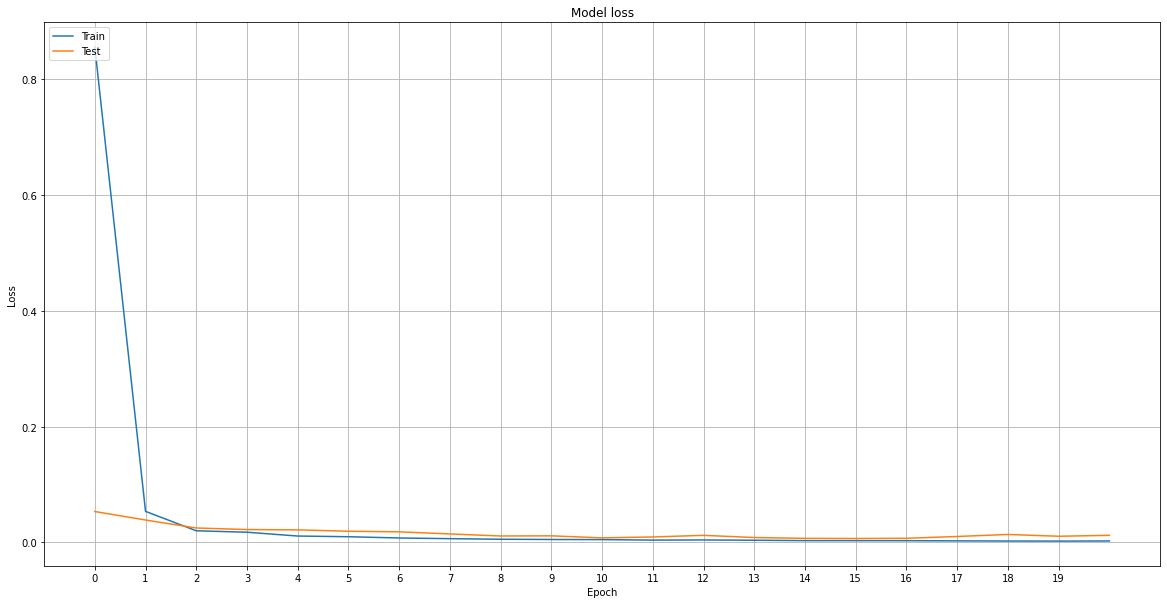

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 1.53
Mean Absolute Percentage Error (MAPE): 6.71 %
Median Absolute Percentage Error (MDAPE): 5.95 %


,MAE,MAPE,MDAPE
0,1.530744,6.707705,5.952118


In [ ]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

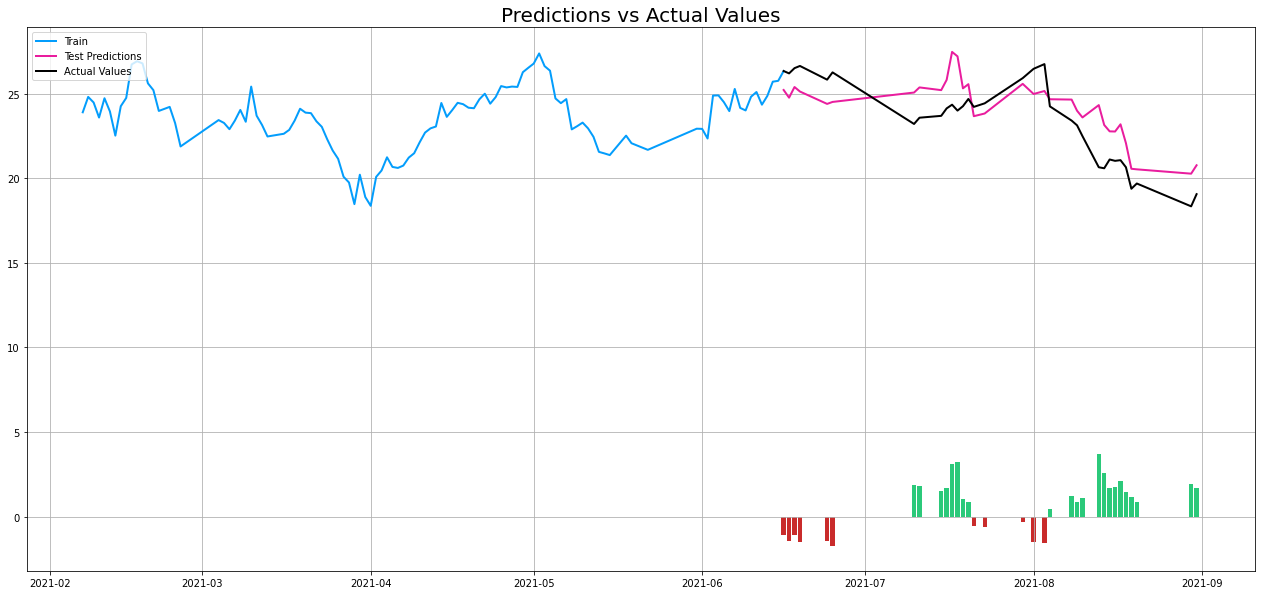

In [ ]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: CLOSE PRICE WITHOUT SENTIMENT

### 1-Day Shift

In [ ]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['High', '5D%Change', 'Volume', 'SD_log', '6Dir', 'SD', '7Dir', '4Dir', 'Dir', '2D%Change', '4D%Change', '2Dir', 'Low', '7D%Change', '3D%Change', '3Dir', 'Daily%Change', '6D%Change', 'Open', '5Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,2Dir(t-1),Low(t-1),7D%Change(t-1),3D%Change(t-1),3Dir(t-1),Daily%Change(t-1),6D%Change(t-1),Open(t-1),5Dir(t-1),Close(t-1)
7,25.500000,2,297.0,373.0,186.5,828.125000,405.0,135.000000,66.853933,583.0,...,1.0,25.510000,11.167733,4.720001,1.0,0.964134,12.023960,26.340000,1.0,26.180000
8,24.920000,3,1275.0,1572.0,786.0,1577.631579,1648.0,549.333333,3884.375000,1680.0,...,0.0,25.129999,9.114245,1.190473,1.0,-2.597404,3.658535,25.709999,1.0,25.500000
9,25.639999,4,1155.0,2430.0,1215.0,288.888889,2727.0,909.000000,1419.736842,2803.0,...,0.0,24.370001,1.300812,-3.895103,0.0,-2.274510,5.862358,25.450001,0.0,24.920000
10,26.620001,1,186.0,528.0,264.0,-81.455633,1531.0,510.333333,-94.505170,4916.0,...,1.0,25.459999,8.920979,-2.062647,0.0,2.889243,2.559998,26.260000,1.0,25.639999
11,26.340000,2,293.0,479.0,239.5,-14.327485,821.0,273.666667,-70.787637,1824.0,...,1.0,26.000000,6.480003,4.392160,1.0,3.822159,5.634921,26.809999,1.0,26.620001


In [ ]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,Low(t-1),7D%Change(t-1),3D%Change(t-1),3Dir(t-1),Daily%Change(t-1),6D%Change(t-1),Open(t-1),5Dir(t-1),Close(t-1),Prediction
239,18.639999,1,2.0,2.0,1.0,100.000000,3.0,1.000000,-96.0,53.0,...,18.170000,-6.551553,-7.164481,0.0,-2.851114,-3.055848,18.799999,0.0,18.400000,18.639999
240,18.860001,2,1.0,3.0,1.5,100.000000,3.0,1.000000,0.0,4.0,...,17.910000,-1.791360,-2.967203,0.0,1.304347,-0.851063,18.000000,0.0,18.639999,18.860001
242,19.059999,4,1.0,1.0,0.5,0.000000,2.0,0.666667,-50.0,4.0,...,18.150000,-5.755390,-0.326084,0.0,-2.757160,-7.467203,18.959999,0.0,18.340000,19.059999
243,17.959999,0,2.0,2.0,1.0,-33.333333,5.0,1.666667,100.0,6.0,...,17.809999,-3.834512,2.253219,1.0,3.925841,-0.780841,18.030001,1.0,19.059999,17.959999
248,18.570000,1,1.0,1.0,0.5,-96.428571,29.0,9.666667,100.0,29.0,...,18.780001,0.424178,0.211645,1.0,0.052827,3.271540,18.780001,0.0,18.940001,18.570000


In [ ]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(166, 43)
(48, 43)


In [ ]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(159, 7, 43) (159,)
(41, 7, 43) (41,)
0.8657294924649557
0.8657294924649557


In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.1043
Epoch 1: val_loss improved from inf to 0.01763, saving model to PLTR_Close_1shift_Baseline.h5
10/10 [==============================] - 5s 182ms/step - loss: 0.1043 - val_loss: 0.0176
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0224
Epoch 2: val_loss improved from 0.01763 to 0.00475, saving model to PLTR_Close_1shift_Baseline.h5
10/10 [==============================] - 1s 80ms/step - loss: 0.0224 - val_loss: 0.0047
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0125
Epoch 3: val_loss improved from 0.00475 to 0.00322, saving model to PLTR_Close_1shift_Baseline.h5
10/10 [==============================] - 1s 80ms/step - loss: 0.0125 - val_loss: 0.0032
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0117
Epoch 4: val_loss did not improve from 0.00322
10/10 [==============================] - 1s 71ms/step - loss: 0.0117 - val_loss: 0.0072
Epoch 

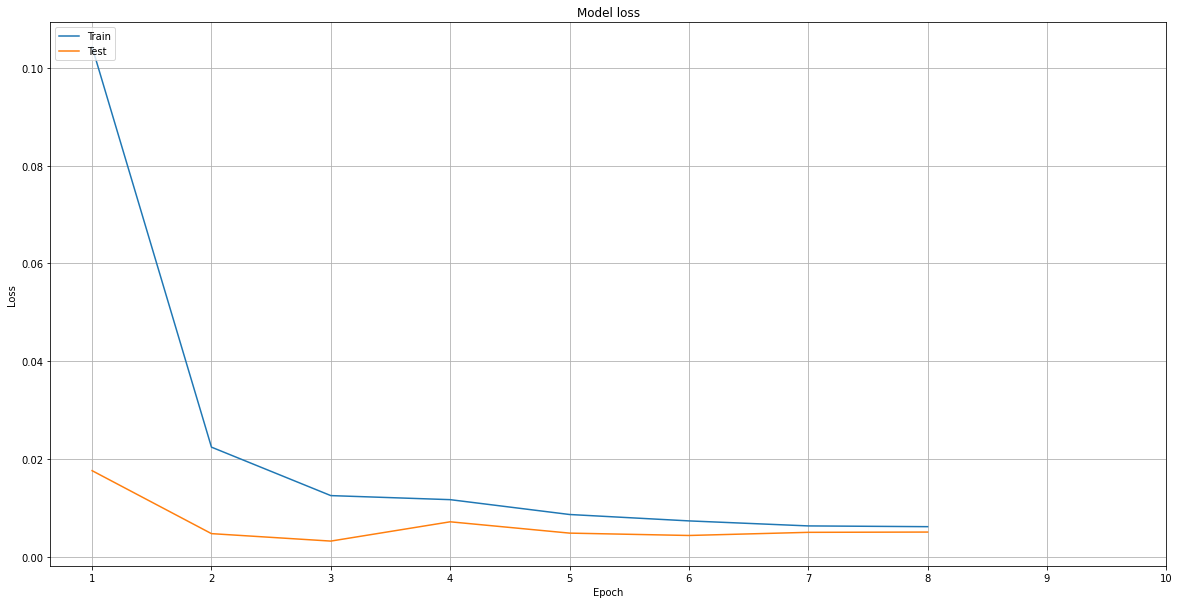

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 0.96
Mean Absolute Percentage Error (MAPE): 4.44 %
Median Absolute Percentage Error (MDAPE): 4.3 %


,MAE,MAPE,MDAPE
0,0.95866,4.437792,4.299478


In [ ]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

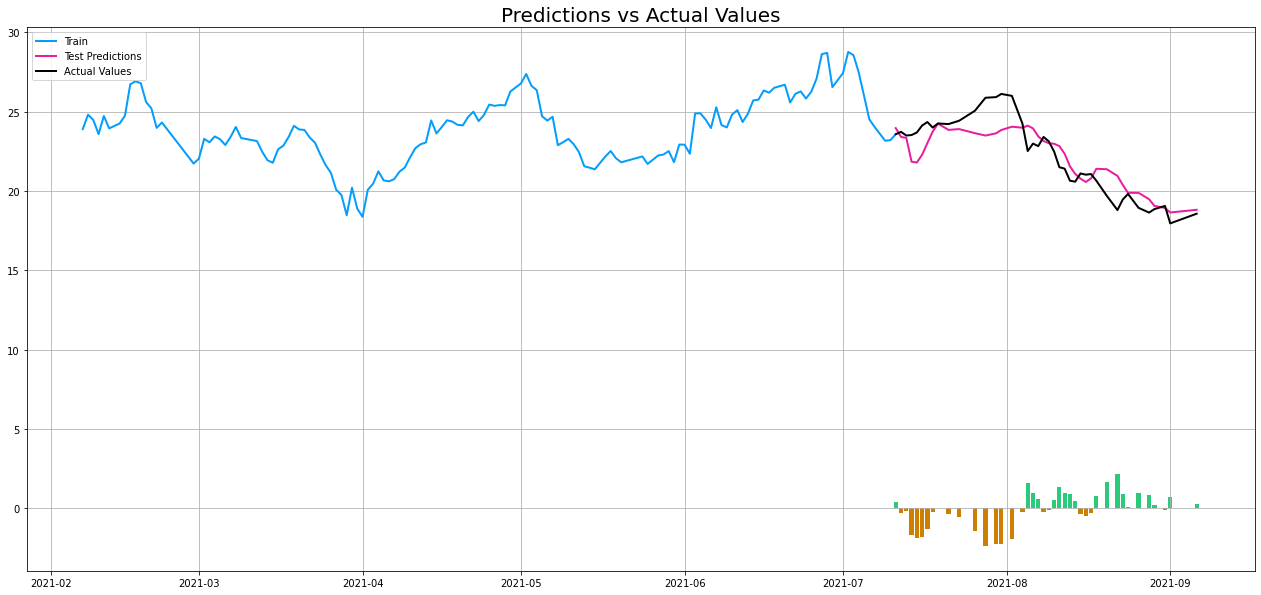

In [ ]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 4-Day Shift

In [ ]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['High', '5D%Change', 'Volume', 'SD_log', '6Dir', 'SD', '7Dir', '4Dir', 'Dir', '2D%Change', '4D%Change', '2Dir', 'Low', '7D%Change', '3D%Change', '3Dir', 'Daily%Change', '6D%Change', 'Open', '5Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,2Dir(t-4),Low(t-4),7D%Change(t-4),3D%Change(t-4),3Dir(t-4),Daily%Change(t-4),6D%Change(t-4),Open(t-4),5Dir(t-4),Close(t-4)
10,26.620001,1,3385.0,4540.0,2270.0,165.490196,5815.0,1938.333333,1039.730640,6112.0,...,1.0,25.510000,11.167733,4.720001,1.0,0.964134,12.023960,26.340000,1.0,26.180000
11,26.340000,2,1003.0,4388.0,2194.0,-13.160173,5543.0,1847.666667,-21.333333,6818.0,...,0.0,25.129999,9.114245,1.190473,1.0,-2.597404,3.658535,25.709999,1.0,25.500000
12,25.980000,3,342.0,1345.0,672.5,-89.896603,4730.0,1576.666667,-70.389610,5885.0,...,0.0,24.370001,1.300812,-3.895103,0.0,-2.274510,5.862358,25.450001,0.0,24.920000
13,32.580002,4,186.0,528.0,264.0,-81.455633,1531.0,510.333333,-94.505170,4916.0,...,1.0,25.459999,8.920979,-2.062647,0.0,2.889243,2.559998,26.260000,1.0,25.639999
14,36.230000,0,201.0,808.0,404.0,-31.399317,1101.0,367.000000,8.064516,1287.0,...,1.0,26.000000,6.480003,4.392160,1.0,3.822159,5.634921,26.809999,1.0,26.620001


In [ ]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,Low(t-4),7D%Change(t-4),3D%Change(t-4),3Dir(t-4),Daily%Change(t-4),6D%Change(t-4),Open(t-4),5Dir(t-4),Close(t-4),Prediction
242,19.059999,4,2.0,2.0,1.0,100.000000,3.0,1.000000,-96.0,53.0,...,18.170000,-6.551553,-7.164481,0.0,-2.851114,-3.055848,18.799999,0.0,18.400000,19.059999
243,17.959999,0,1.0,1.0,0.5,0.000000,2.0,0.666667,-50.0,4.0,...,17.910000,-1.791360,-2.967203,0.0,1.304347,-0.851063,18.000000,0.0,18.639999,17.959999
244,18.900000,1,3.0,4.0,2.0,100.000000,4.0,1.333333,200.0,5.0,...,17.995001,0.319156,-0.422386,0.0,1.180264,-3.083240,18.370001,0.0,18.860001,18.900000
246,18.930000,3,2.0,2.0,1.0,-33.333333,5.0,1.666667,100.0,6.0,...,17.809999,-3.834512,2.253219,1.0,3.925841,-0.780841,18.030001,1.0,19.059999,18.930000
249,18.170000,2,28.0,28.0,14.0,100.000000,28.0,9.333333,100.0,28.0,...,18.650000,2.608693,-0.944388,0.0,-0.105823,1.287552,18.650000,1.0,18.879999,18.170000


In [ ]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(160, 43)
(46, 43)


In [ ]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(153, 7, 43) (153,)
(39, 7, 43) (39,)
0.8380998405981623
0.8380998405981623


In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.1059
Epoch 1: val_loss improved from inf to 0.01737, saving model to PLTR_Close_4shift_Baseline.h5
10/10 [==============================] - 5s 174ms/step - loss: 0.1059 - val_loss: 0.0174
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0203
Epoch 2: val_loss improved from 0.01737 to 0.00668, saving model to PLTR_Close_4shift_Baseline.h5
10/10 [==============================] - 1s 76ms/step - loss: 0.0203 - val_loss: 0.0067
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0104
Epoch 3: val_loss did not improve from 0.00668
10/10 [==============================] - 1s 71ms/step - loss: 0.0104 - val_loss: 0.0125
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0090
Epoch 4: val_loss did not improve from 0.00668
10/10 [==============================] - 1s 68ms/step - loss: 0.0090 - val_loss: 0.0074
Epoch 5/100
 9/10 [==========================>...] - ETA:

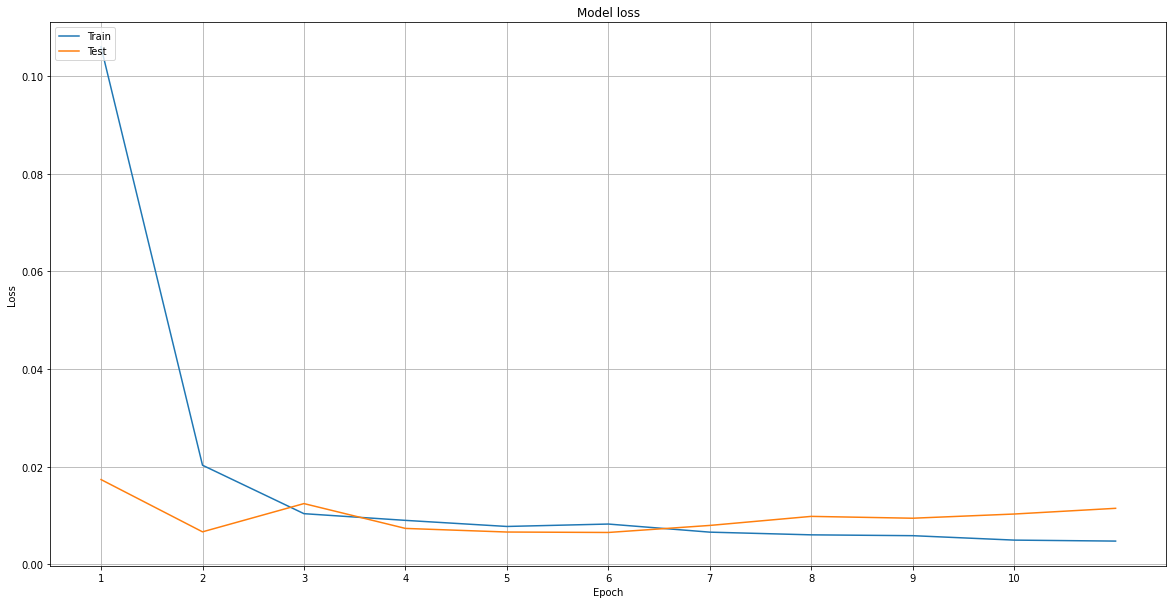

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 1.61
Mean Absolute Percentage Error (MAPE): 7.61 %
Median Absolute Percentage Error (MDAPE): 7.36 %


,MAE,MAPE,MDAPE
0,1.614207,7.611723,7.363379


In [ ]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

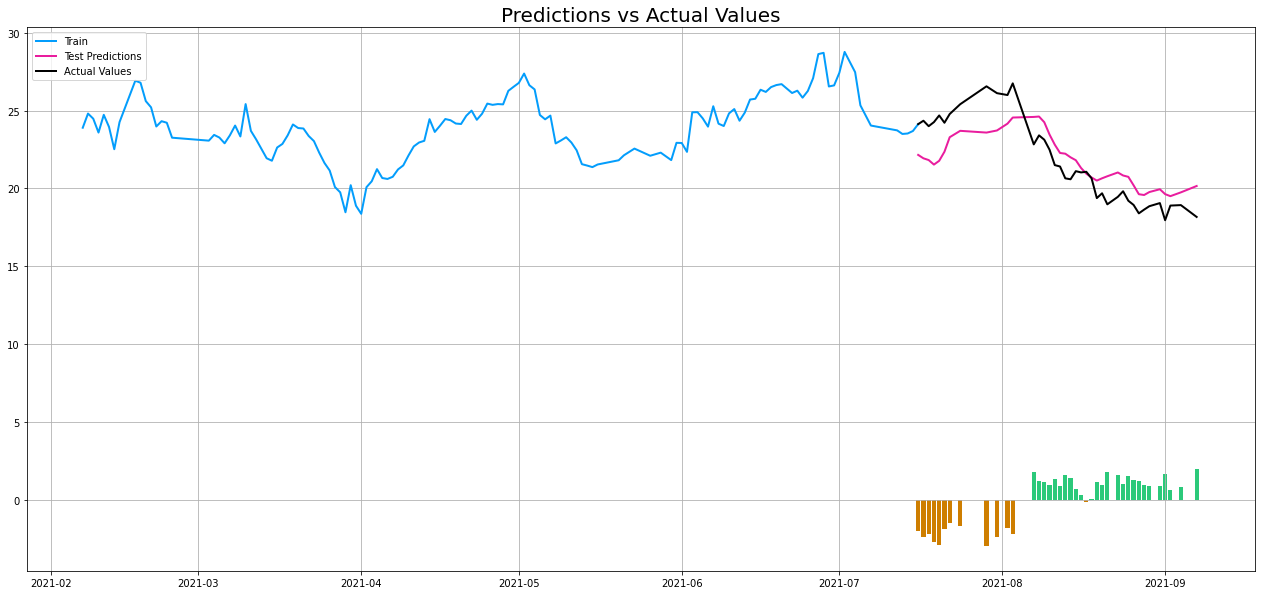

In [ ]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 7-Day Shift

In [ ]:
bdep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['High', '5D%Change', 'Volume', 'SD_log', '6Dir', 'SD', '7Dir', '4Dir', 'Dir', '2D%Change', '4D%Change', '2Dir', 'Low', '7D%Change', '3D%Change', '3Dir', 'Daily%Change', '6D%Change', 'Open', '5Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,2Dir(t-7),Low(t-7),7D%Change(t-7),3D%Change(t-7),3Dir(t-7),Daily%Change(t-7),6D%Change(t-7),Open(t-7),5Dir(t-7),Close(t-7)
13,32.580002,4,3385.0,4540.0,2270.0,165.490196,5815.0,1938.333333,1039.730640,6112.0,...,1.0,25.510000,11.167733,4.720001,1.0,0.964134,12.023960,26.340000,1.0,26.180000
14,36.230000,0,186.0,528.0,264.0,-81.455633,1531.0,510.333333,-94.505170,4916.0,...,0.0,25.129999,9.114245,1.190473,1.0,-2.597404,3.658535,25.709999,1.0,25.500000
15,35.369999,1,293.0,479.0,239.5,-14.327485,821.0,273.666667,-70.787637,1824.0,...,0.0,24.370001,1.300812,-3.895103,0.0,-2.274510,5.862358,25.450001,0.0,24.920000
16,39.000000,2,607.0,900.0,450.0,226.344086,1086.0,362.000000,77.485380,1428.0,...,1.0,25.459999,8.920979,-2.062647,0.0,2.889243,2.559998,26.260000,1.0,25.639999
17,35.660000,3,201.0,808.0,404.0,-31.399317,1101.0,367.000000,8.064516,1287.0,...,1.0,26.000000,6.480003,4.392160,1.0,3.822159,5.634921,26.809999,1.0,26.620001


In [ ]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,Low(t-7),7D%Change(t-7),3D%Change(t-7),3Dir(t-7),Daily%Change(t-7),6D%Change(t-7),Open(t-7),5Dir(t-7),Close(t-7),Prediction
241,18.340000,3,107.0,107.0,53.5,10600.0,108.0,36.000000,5250.0,110.0,...,19.070000,-7.465533,-1.168113,0.0,3.510638,-7.641199,19.260000,0.0,19.459999,18.340000
242,19.059999,4,50.0,157.0,78.5,100.0,157.0,52.333333,4900.0,158.0,...,19.030001,-5.932606,4.425712,1.0,1.849952,-4.019370,19.510000,1.0,19.820000,19.059999
243,17.959999,0,2.0,2.0,1.0,100.0,3.0,1.000000,-96.0,53.0,...,19.040001,-6.973368,2.180850,1.0,-3.077702,-0.877193,19.950001,0.0,19.209999,17.959999
244,18.900000,1,1.0,3.0,1.5,100.0,3.0,1.000000,0.0,4.0,...,18.700001,-2.270375,-2.672141,0.0,-1.405510,-3.809040,19.280001,0.0,18.940001,18.900000
246,18.930000,3,1.0,1.0,0.5,0.0,2.0,0.666667,-50.0,4.0,...,17.910000,-1.791360,-2.967203,0.0,1.304347,-0.851063,18.000000,0.0,18.639999,18.930000


In [ ]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(165, 43)
(48, 43)


In [ ]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(158, 7, 43) (158,)
(41, 7, 43) (41,)
0.6131846889546944
0.6131846889546944


In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.0583
Epoch 1: val_loss improved from inf to 0.03009, saving model to PLTR_Close_7shift_Baseline.h5
10/10 [==============================] - 6s 178ms/step - loss: 0.0583 - val_loss: 0.0301
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0160
Epoch 2: val_loss improved from 0.03009 to 0.01690, saving model to PLTR_Close_7shift_Baseline.h5
10/10 [==============================] - 1s 80ms/step - loss: 0.0160 - val_loss: 0.0169
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0103
Epoch 3: val_loss did not improve from 0.01690
10/10 [==============================] - 1s 71ms/step - loss: 0.0103 - val_loss: 0.0211
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0071
Epoch 4: val_loss did not improve from 0.01690
10/10 [==============================] - 1s 69ms/step - loss: 0.0071 - val_loss: 0.0266
Epoch 5/100
10/10 [==============================] - ETA:

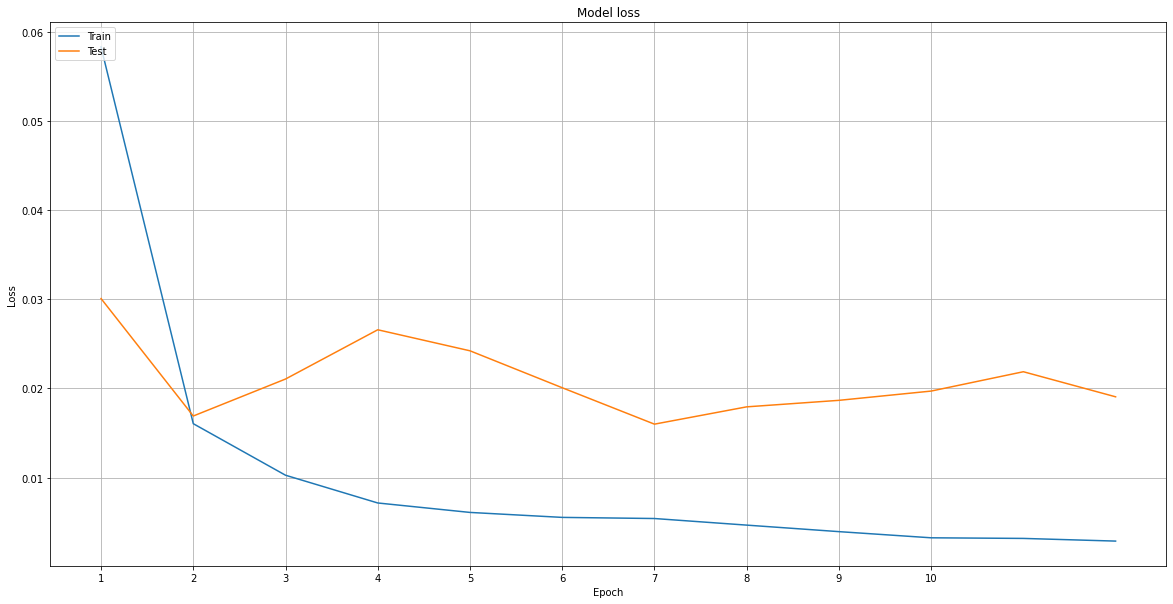

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 2.21
Mean Absolute Percentage Error (MAPE): 10.12 %
Median Absolute Percentage Error (MDAPE): 8.92 %


,MAE,MAPE,MDAPE
0,2.213978,10.116495,8.918172


In [ ]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

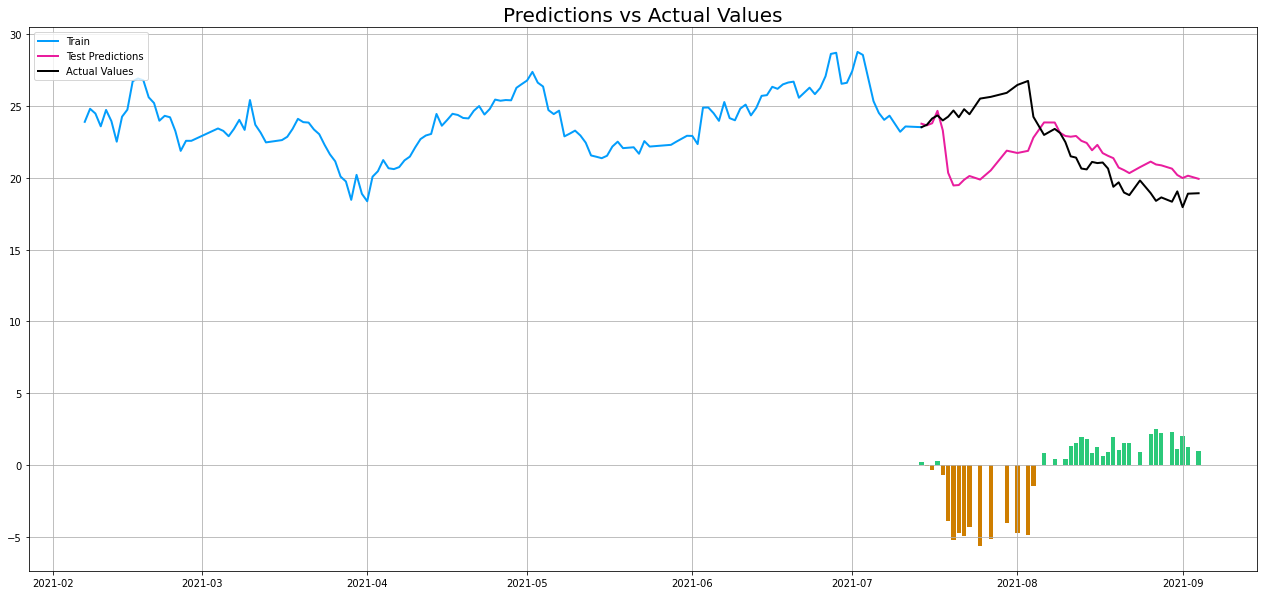

In [ ]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## Overall Results

In [ ]:
results_df =pd.DataFrame.from_dict(results_dict).transpose().reset_index()
results_df['ticker'] = results_df['index'].str.split('_').str[0]
results_df['shift'] = results_df['index'].str.split('_').str[1]
results_df['metric'] = results_df['index'].str.split('_').str[2]
results_df['scenario'] = results_df['index'].str.split('_').str[3]
results_df['scenario'].fillna(value = 'sentiment', inplace = True)
results_df['results_%'] = results_df[0]
results_df.drop(['index', 0], axis = 1, inplace = True)
results_df.sort_values(['metric', 'shift','scenario'], inplace = True)
results_df = results_df.pivot(index = ['shift', 'metric'], columns = 'scenario', values = 'results_%').reset_index()
results_df

scenario,shift,metric,baseline,sentiment
0,1dayshift,MAE,0.958660,1.014418
1,1dayshift,MAPE,4.437792,4.348581
2,1dayshift,MDAPE,4.299478,3.464322
3,4dayshift,MAE,1.614207,1.669695
4,4dayshift,MAPE,7.611723,7.230776
5,4dayshift,MDAPE,7.363379,6.907448
6,7dayshift,MAE,2.213978,1.530744
7,7dayshift,MAPE,10.116495,6.707705
8,7dayshift,MDAPE,8.918172,5.952118


In [ ]:
results_df.to_csv('{}_LSTM.csv'.format(ticker), index = False)

scenario           baseline  sentiment
shift     metric                      
1dayshift MAE      0.958660   1.014418
          MAPE     4.437792   4.348581
          MDAPE    4.299478   3.464322
4dayshift MAE      1.614207   1.669695
          MAPE     7.611723   7.230776
          MDAPE    7.363379   6.907448
7dayshift MAE      2.213978   1.530744
          MAPE    10.116495   6.707705
          MDAPE    8.918172   5.952118